## Visualizing CNN Filters and Features

In this demo, we'll try to visualize CNN filters as well as its corresponding feature map output.

### Load Model

Run and save the model found in our previous [CNN tutorial](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/BuildingBlocks/cnn_demo.ipynb) using `torch.save()`. We will use the saved weights for this demo.

In [1]:
import pytorch_lightning as pl
import torch.nn as nn

class CNN(pl.LightningModule):
    def __init__(self, num_channel, num_class):
        super().__init__()
        self.num_channel = num_channel
        self.num_class = num_class

        self.conv1 = nn.Conv2d(num_channel, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, num_class)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

Load the saved weights.

In [2]:
import torch

model = CNN(num_channel=3, num_class=10)
model.load_state_dict(torch.load('cnn3l_dict.pt'))

<All keys matched successfully>

### CNN Filters

We extract the weights of our `conv` layers. The weights contain our filter information.

In [3]:
weights, layers = [], []
model_children = list(model.children())

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        weights.append(model_children[i].weight)
        layers.append(model_children[i])
print("Num conv layers: {}".format(len(weights)))

Num conv layers: 3


Our filters are stored in the ff shape `(N,C,H,W)`, where:
 * `N` represent number of filters
 * `C` is the number of input channels
 * `H` x `W` is the dimension of our filter

In [4]:
for weight in weights:
    print(weight.shape)
    print("\tNum filters: {}".format(weight.shape[0]))
    print("\tInput channel: {}".format(weight.shape[1]))
    print("\tFilter size: {} x {}\n".format(weight.shape[2], weight.shape[3]))

torch.Size([32, 3, 3, 3])
	Num filters: 32
	Input channel: 3
	Filter size: 3 x 3

torch.Size([64, 32, 3, 3])
	Num filters: 64
	Input channel: 32
	Filter size: 3 x 3

torch.Size([128, 64, 3, 3])
	Num filters: 128
	Input channel: 64
	Filter size: 3 x 3



Let us try to visualize our first conv layer filters. Note from our earlier loop, this is stored in `weights[0]`.

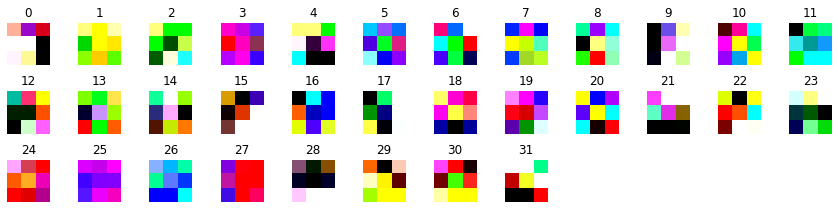

In [5]:
from matplotlib import pyplot as plt
import numpy as np

cols = 12
rows = int(np.ceil(weights[0].shape[0]/12))

plt.figure(figsize=(cols, rows))
for i in range(len(weights[0])): # c, h, w
    filter = weights[0][i].detach().cpu().numpy()
    filter = filter.transpose((1,2,0)) # h, w, c
    
    filter = (filter-np.mean(filter))/np.std(filter)
    filter = np.minimum(1,np.maximum(0,(filter + 0.5)))
    
    plt.subplot(rows, cols, i+1)
    plt.imshow(filter)
    plt.axis('off')
    plt.title(str(i))
    
plt.tight_layout()
plt.show()

### CNN Feature Maps

Feature maps are the result when filters (for example, the filters we just visualized earlier from our first `conv` layer) are applied to the image. Visualizing these feature maps will tell us what sort of features our CNN is focusing on.

Some toolkits, such as in our previous [Timm demo](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/Toolkits/timm_demo.ipynb), provide easier access and visualizations of these features on some well-known architectures. So you may opt to use these libraries instead as well.

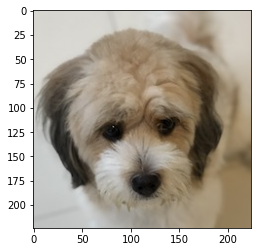

In [6]:
from PIL import Image

image = Image.open('../Toolkits/resources/aki_dog.jpg')
plt.imshow(image)
plt.show()

We apply transformation to our image.

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

For the calculation of shapes, please refer to the notes [here](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/Notes/NN%20IO%20Shape%20Calculation.pdf). Do note that unlike the `feedforward` process, we did **not** consider the `maxpool` layers.

In [8]:
fmaps = []

input = transform(image).unsqueeze(0)
for layer in layers[0:]:
    input = layer(input)
    fmaps.append(input)
    print(input.shape)

torch.Size([1, 32, 30, 30])
torch.Size([1, 64, 28, 28])
torch.Size([1, 128, 26, 26])


We visualize our feature map.

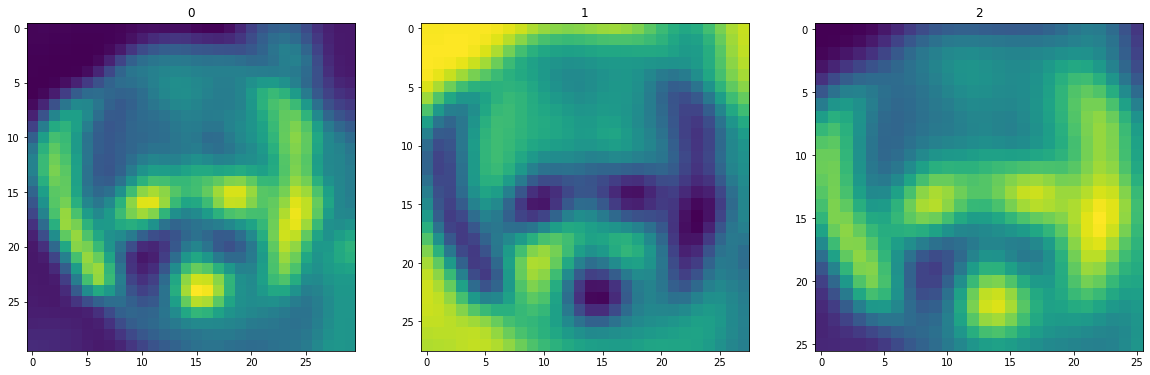

In [9]:
fig = plt.figure(figsize=(20,20))
rows, cols = 1, len(fmaps)
for i in range(len(fmaps)):
    fmap = fmaps[i].squeeze().sum(0).detach().numpy()
    
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(fmap)
    plt.title(str(i))

As an exercise, you may opt to freely change the dimension of our CNN model (change filter sizes or the depth of our model), retrain it and then inspect its filters and output.

Other recommended read about CNN: [Stanford's CS231N](https://cs231n.github.io/convolutional-networks/#conv)